# **Introduction**

**Final Project**

**Customer Lifetime Value Prediction**

## **Identity**

| Name                  | Class                                      | Batch   | Dataset | Create Date  |
| --------------------- | ------------------------------------------ | ------- | -------- | ------------ | 
| Muhammad Nur Arifin   | Business Intelligence Specialized Program  | 1.0     | [here](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II) | 2020-03-19   |


About Dataset: This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011. The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

Attribute Information:

- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 
- Description: Product (item) name. Nominal. 
- Quantity: The quantities of each product (item) per transaction. Numeric. 
- InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated. 
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£). 
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. 
- Country: Country name. Nominal. The name of the country where a customer resides.

# Import Library

In [1]:
# numpy for array manipulation
import numpy as np
# pandas for dataframe manipulation
import pandas as pd
# matplotlib for data visualization
import matplotlib.pyplot as plt

#split training set and test set
from sklearn.model_selection import train_test_split
# import regression model
from sklearn.linear_model import LinearRegression
# import metrics module from scikit-learn
from sklearn import metrics

# load lifetimes plotting module
from lifetimes.plotting import *
# load lifetimes utils module
from lifetimes.utils import *
# load BetaGeoFitter model
from lifetimes import BetaGeoFitter
# load GammaGammaFitter
from lifetimes import GammaGammaFitter

# Data visualization libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

# import datetime for date manipulation
import datetime as dt

# Data Loading

In [16]:
# Load the data
raw_data = pd.read_excel("/Users/muhammadipink/Documents/Bootcamp/diBimbing/Final Project/online_retail_II.xlsx")

# Read teh data
raw_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [17]:
# Know the columns and their value types
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


# Data Cleansing
Before we proceed with the analysis, we should check for possible missing values in the dataset

In [18]:
# Detects a missing/na value 
percent_missing = raw_data. isnull(). sum() * 100 / len(raw_data)
percent_missing

Invoice         0.000000
StockCode       0.000000
Description     0.557225
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    20.539488
Country         0.000000
dtype: float64

Missing value is in the id column and the amount is 20%. We'll throw it away because we can't analyze the data without identifier

In [19]:
# Drop the missing value
raw_data = raw_data.dropna(subset=['Customer ID'], how='all')
raw_data.shape

(417534, 8)

In [20]:
# Check the result after we drop the missing value
raw_data.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

# Data Prepocessing

In [21]:
# Change 'Invoice_Date' to 'date' type
raw_data["InvoiceDate"] = pd.to_datetime(raw_data["InvoiceDate"], infer_datetime_format=True, errors='coerce').dt.date
raw_data["InvoiceDate"] = pd.to_datetime(raw_data["InvoiceDate"], infer_datetime_format=True, errors='coerce')

In [22]:
# Check the changes
raw_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom


In [23]:
# Check the summary
raw_data.describe()

,Quantity,Price,Customer ID
count,417534.000000,417534.000000,417534.000000
mean,12.758815,3.887547,15360.645478
std,101.220424,71.131797,1680.811316
min,-9360.000000,0.000000,12346.000000
25%,2.000000,1.250000,13983.000000
50%,4.000000,1.950000,15311.000000
75%,12.000000,3.750000,16799.000000
max,19152.000000,25111.090000,18287.000000


Here, we can observe some of the customers have ordered in a negative quantity, which is not possible. So, we need to filter Quantity greater than zero.

In [24]:
# Filtering quantity and price greater than zero
raw_data = raw_data[(raw_data["Quantity"] > 0)]
raw_data = raw_data[(raw_data["Price"] > 0)]
raw_data.shape

(407664, 8)

# Data Exploration

In [96]:
# check 10 countries that generate the most revenue 
raw_data['Country'].value_counts().head(10)

United Kingdom    370929
EIRE                8507
Germany             7654
France              5470
Netherlands         2729
Spain               1235
Switzerland         1170
Belgium             1037
Portugal             984
Sweden               868
Name: Country, dtype: int64

<AxesSubplot:>

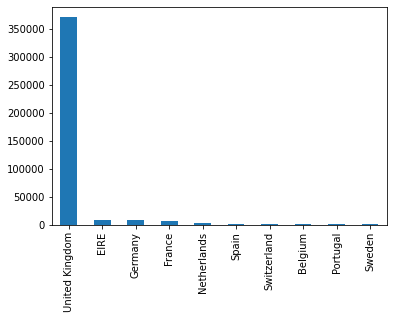

In [99]:
# visualize 10 countries that generate the most revenue 
raw_data['Country'].value_counts().head(10).plot(kind='bar')

In [10]:
raw_data['InvoiceDate'] = pd.to_datetime(raw_data['InvoiceDate'])

raw_data['Year'] = raw_data["InvoiceDate"].apply(lambda x: x.year)
raw_data['Month'] = raw_data["InvoiceDate"].apply(lambda x: x.month)
raw_data['MonthYear'] = raw_data["InvoiceDate"].apply(lambda x: x.strftime("%B %Y"))
raw_data['Weekday'] = raw_data["InvoiceDate"].apply(lambda x: x.weekday())
raw_data['Day'] = raw_data["InvoiceDate"].apply(lambda x: x.day)
raw_data['Hour'] = raw_data["InvoiceDate"].apply(lambda x: x.hour)

# Create total purchase
raw_data['Total_Purchase'] = raw_data['Quantity'] * raw_data['Price'] # Calulate total purchase

In [11]:
hourly_sales = raw_data.groupby('Hour')['Total_Purchase'].sum().sort_index(ascending=True)

data = [go.Bar(x=hourly_sales.index, 
               y=hourly_sales.values)]

layout = go.Layout(title="Hourly sales", title_x=0.5)

fig = go.Figure(data=data, layout=layout)

fig.show()

#### Filter required Columns
Here, we can filter the necessary columns for calculating CLTV. We only need here five columns CustomerID, InvoiceDate, InvoiceNo, Quantity, and UnitPrice.
 - CustomerID    > will uniquely define our customers.
 - InvoiceDate   > help us calculate numbers of days customer stayed with the product.
 - Invoice       > helps us to count the number of time transaction performed(frequency).
 - Quantity      > is purchased item units in each transaction
 - UnitPrice     > of each unit purchased by the customer will help us to calculate the total purchased amount.

In [25]:
# select certain column
data = raw_data[[
  "Customer ID","InvoiceDate",
  "Invoice","Quantity","Price"
]]

# Renaming the columns
data = data.rename(columns={'Customer ID':'Customer_ID',
'InvoiceDate':'Invoice_Date'})

In [26]:
# Create total purchase
data['Total_Purchase'] = data['Quantity'] * data['Price'] # Calulate total purchase

In [27]:
# Check the total purchase column
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407664 entries, 0 to 525460
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Customer_ID     407664 non-null  float64       
 1   Invoice_Date    407664 non-null  datetime64[ns]
 2   Invoice         407664 non-null  object        
 3   Quantity        407664 non-null  int64         
 4   Price           407664 non-null  float64       
 5   Total_Purchase  407664 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 21.8+ MB


Here, we are going to perform the following operations:
- Calculate the number of days between the present date and the date of last purchase from each customer.
- Calculate the number of orders for each customer.
- Calculate sum of purchase price for each customer.

In [28]:
data_clv = data.groupby(
    'Customer_ID', as_index = False
).agg(
    {
      'Invoice_Date': lambda date: (date.max() - date.min()).days,
      'Invoice': lambda num: len(num),
      'Quantity': lambda quant: quant.sum(),
      'Total_Purchase': lambda price: price.sum()
    }
)

data_clv.head()

,Customer_ID,Invoice_Date,Invoice,Quantity,Total_Purchase
0,12346.0,196,33,70,372.86
1,12347.0,37,71,828,1323.32
2,12348.0,0,20,373,222.16
3,12349.0,182,102,993,2671.14
4,12351.0,0,21,261,300.93


In [29]:
# Renaming the columns
data_clv.columns=['customer_id','num_days','num_transactions','num_units','spent_money']
data_clv.head()

,customer_id,num_days,num_transactions,num_units,spent_money
0,12346.0,196,33,70,372.86
1,12347.0,37,71,828,1323.32
2,12348.0,0,20,373,222.16
3,12349.0,182,102,993,2671.14
4,12351.0,0,21,261,300.93


In [18]:
total_freq = data_clv['num_transactions'].sum()
total_gmv = data_clv['spent_money'].sum()

display("Total Transaction:", total_freq)
display("Total GMV:", total_gmv)

'Total Transaction:'

407664

'Total GMV:'

8832003.274

## Calculate CLTV using following formula:
CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

Customer Value = Average Order Value * Purchase Frequency

In [30]:
# Average Order Value
data_clv['avg_order_value'] = data_clv['spent_money']/data_clv['num_transactions']

In [31]:
data_clv.head()

,customer_id,num_days,num_transactions,num_units,spent_money,avg_order_value
0,12346.0,196,33,70,372.86,11.298788
1,12347.0,37,71,828,1323.32,18.638310
2,12348.0,0,20,373,222.16,11.108000
3,12349.0,182,102,993,2671.14,26.187647
4,12351.0,0,21,261,300.93,14.330000


##  Calculate Purchase Frequency, Calculate Repeat Rate and Churn Rate

In [32]:
# Purchase frequency
purchase_frequency = sum(data_clv['num_transactions'])/data_clv.shape[0]

In [33]:
# Repeat Rate
repeat_rate = data_clv[data_clv.num_transactions > 1].shape[0]/data_clv.shape[0]

In [34]:
# Churn Rate
churn_rate = 1-repeat_rate

In [35]:
print("purchase frequencies: {}".format(purchase_frequency))
print("repeat rate: {}".format(repeat_rate))
print("churn rate: {}".format(churn_rate))

purchase frequencies: 94.5417439703154
repeat rate: 0.9788961038961039
churn rate: 0.02110389610389607


## Calculate Profit Margin
Profit margin is the commonly used profitability ratio. It represents how much percentage of total sales has earned as the gain. 
Based on this article [here](http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/margin.html), a good benchmark for net profit margin for e-commerce is around 7.26%. Let's assume our business has approx 7% profit on the total sale.

In [36]:
# Profit Margin
data_clv['profit_margin'] = data_clv['spent_money']*0.07

In [37]:
data_clv.head()

,customer_id,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin
0,12346.0,196,33,70,372.86,11.298788,26.1002
1,12347.0,37,71,828,1323.32,18.638310,92.6324
2,12348.0,0,20,373,222.16,11.108000,15.5512
3,12349.0,182,102,993,2671.14,26.187647,186.9798
4,12351.0,0,21,261,300.93,14.330000,21.0651


In [38]:
data_clv['profit_margin'].sum()

618240.22918

## Calcualte Customer Lifetime Value

In [39]:
# Customer Value
data_clv['CLV']=(data_clv['avg_order_value']*purchase_frequency)/churn_rate

In [40]:
# Create Customer Lifetime Value
data_clv['cust_lifetime_value']=data_clv['CLV']*data_clv['profit_margin']

In [41]:
# Check the result
data_clv.head()

,customer_id,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value
0,12346.0,196,33,70,372.86,11.298788,26.1002,50616.583097,1.321103e+06
1,12347.0,37,71,828,1323.32,18.638310,92.6324,83496.351104,7.734467e+06
2,12348.0,0,20,373,222.16,11.108000,15.5512,49761.886945,7.738571e+05
3,12349.0,182,102,993,2671.14,26.187647,186.9798,117316.054402,2.193573e+07
4,12351.0,0,21,261,300.93,14.330000,21.0651,64195.880440,1.352293e+06


# Prediction Model for CLTV
Let's build the CLTV prediction model. 
Here, we are going to predict CLTV using Linear Regression Model.
Let's first use the data loaded and filtered above.

Extract month and year from ```[Invoice_Date]```.

In [42]:
# Create new dataset using df.copy() for prediction CLV
data_predict_clv = data.copy()

# Create a new column containing what month the transaction occurred referring to the Invoice_Date column
data_predict_clv['month_yr'] = data_predict_clv['Invoice_Date'].apply(
    lambda x: x.strftime('%b-%Y'))

In [43]:
# Check the result
data_predict_clv.head()

,Customer_ID,Invoice_Date,Invoice,Quantity,Price,Total_Purchase,month_yr
0,13085.0,2009-12-01,489434,12,6.95,83.4,Dec-2009
1,13085.0,2009-12-01,489434,12,6.75,81.0,Dec-2009
2,13085.0,2009-12-01,489434,12,6.75,81.0,Dec-2009
3,13085.0,2009-12-01,489434,48,2.10,100.8,Dec-2009
4,13085.0,2009-12-01,489434,24,1.25,30.0,Dec-2009


In [44]:
custom_aggregation = {}

custom_aggregation["Invoice_Date"] = lambda x:x.iloc[0]
custom_aggregation["month_yr"] = lambda x:x.iloc[0]

custom_aggregation["Total_Purchase"] = 'sum'

In [45]:
sales_invoices_montly = data_predict_clv.groupby('month_yr').agg(custom_aggregation).sort_values(by='Invoice_Date')
sales_invoices_montly

,Invoice_Date,month_yr,Total_Purchase
month_yr,,,
Dec-2009,2009-12-01,Dec-2009,686654.160
Jan-2010,2010-01-04,Jan-2010,557319.062
Feb-2010,2010-02-01,Feb-2010,506371.066
Mar-2010,2010-03-01,Mar-2010,699608.991
Apr-2010,2010-04-01,Apr-2010,594609.192
May-2010,2010-05-02,May-2010,599985.790
Jun-2010,2010-06-01,Jun-2010,639066.580
Jul-2010,2010-07-01,Jul-2010,591636.740
Aug-2010,2010-08-01,Aug-2010,604242.650


In [46]:
data_fig = [go.Scatter(x=sales_invoices_montly.index, 
                   y=sales_invoices_montly['Total_Purchase'])]

layout = go.Layout(title="Total Sales", title_x=0.5)

fig = go.Figure(data=data_fig, layout=layout)
fig.update_xaxes(type='category')

fig.show()

The pivot table takes the columns as input, and groups the entries into a two-dimensional table in such a way that provides a multidimensional summarization of the data.

In [47]:
# Pivoting
sales = data_predict_clv.pivot_table(
    index=['Customer_ID'],
    columns=['month_yr'],
    values='Total_Purchase',
    aggfunc='sum',
    fill_value=0
).reset_index()

In [48]:
# Chect the pivot table
sales.head()

month_yr,Customer_ID,Apr-2010,Aug-2010,Dec-2009,Dec-2010,Feb-2010,Jan-2010,Jul-2010,Jun-2010,Mar-2010,May-2010,Nov-2010,Oct-2010,Sep-2010
0,12346.0,0.00,0.0,113.5,0.00,0.0,90.0,0.0,142.31,27.05,0.0,0.00,0.00,0.00
1,12347.0,0.00,0.0,0.0,711.79,0.0,0.0,0.0,0.00,0.00,0.0,0.00,611.53,0.00
2,12348.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,222.16
3,12349.0,1068.52,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,200.0,0.00,1402.62,0.00
4,12351.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,300.93,0.00,0.00


In [49]:
# Sum all the months sales and create the CLV
sales['CLV'] = sales.iloc[:,2:].sum(axis=1)

In [50]:
# Check CLV column
sales.head()

month_yr,Customer_ID,Apr-2010,Aug-2010,Dec-2009,Dec-2010,Feb-2010,Jan-2010,Jul-2010,Jun-2010,Mar-2010,May-2010,Nov-2010,Oct-2010,Sep-2010,CLV
0,12346.0,0.00,0.0,113.5,0.00,0.0,90.0,0.0,142.31,27.05,0.0,0.00,0.00,0.00,372.86
1,12347.0,0.00,0.0,0.0,711.79,0.0,0.0,0.0,0.00,0.00,0.0,0.00,611.53,0.00,1323.32
2,12348.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,222.16,222.16
3,12349.0,1068.52,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,200.0,0.00,1402.62,0.00,1602.62
4,12351.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,300.93,0.00,0.00,300.93


### Selecting Feature
Here, we need to divide the given columns into two types of variables dependent(or target variable) and independent variable(or feature variables). Select latest 6 month as independent variable.

In [51]:
X=sales[['Dec-2010','Nov-2010', 'Oct-2010','Sep-2010','Aug-2010','Jul-2010']]
y=sales[['CLV']]

### Splitting Data
To understand model performance, dividing the dataset into a training set and a test set is a good strategy.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    random_state=42
)

### Modeling
Here we will use a linear regression model let's start by defining the model first

In [53]:
# Define the model
lin_reg_model = LinearRegression()

In [54]:
# Fit the model to the training data (learn the coefficients)
lin_reg_model.fit(X_train, y_train)

LinearRegression()

In [55]:
# Print the intercept and coefficients
print(lin_reg_model.intercept_)
print(lin_reg_model.coef_)

[59.55055263]
[[0.16219042 1.49057398 1.46062598 1.76024361 3.06604961 2.23647977]]


In [56]:
# Make predictions on the testing set
y_pred = lin_reg_model.predict(X_test)

### Model Fit 

In [57]:
# Compute the R Square for model
print("R-Square:",metrics.r2_score(y_test, y_pred))

R-Square: 0.8790548493384586


> This model has a high enough R-squared (0.87). This means that the selected 6 variables (6 months) have been able to represent almost 90%. It can be optimized by taking more variables

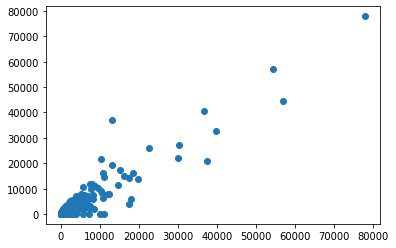

In [58]:
plt.scatter(x=y_test,y=y_pred);

In this plotting we can see the pattern forms a linear line and this shows that our baseline model is fitting well

## Model Evaluation
For regression problems following evaluation metrics used:
- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)

In [59]:
# calculate MAE using scikit-learn
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))

#calculate mean squared error
print("MSE",metrics.mean_squared_error(y_test, y_pred))

# compute the RMSE of our predictions
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 663.9828325780144
MSE 2599173.0953049613
RMSE: 1612.195117008162


> RMSE is more popular than MSE and MAE because RMSE is interpretable with y because of the same units.

# Pros and Cons of CLTV
- CLTV helps us to design an effective business plan and also provide a chance to scale our business.
- CLTV draw meaningful customer segments these segment can help us to identify needs of the different-different segment. 
- CLTV can figure out most profitable customers, but how we are going to make a profit from them, it depends on our strategy. 
Generally, CLTV models are confused and misused. Obsession with CLTV may create blunders. Companies only focus on finding the best customer group and focusing on them and repeat the business, but it’s also important to give attention to other customers.

# CLTV Model Definition
For the CLTV models, the following nomenclature is used:
- Frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases.
- T represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- Recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

# Modeling Using Lifetimes
We have some cleaning to do, then create a new dataframe that contains CustomerID, InvoiceDate and add a new column — sales:

In [60]:
# Make new dataset using .copy()
data_lifetimes = raw_data.copy()
data_lifetimes.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom


In [61]:
# only pick data with no null data
data_lifetimes = data_lifetimes[pd.notnull(data_lifetimes['Customer ID'])]
# pick data with quantity greater than 0
data_lifetimes = data_lifetimes[(data_lifetimes['Quantity']>0)]
# Create sales or GMV based on quantity * unit price
data_lifetimes['Sales'] = data_lifetimes['Quantity'] * data_lifetimes['Price']
# pick only certain variables
data_lifetimes = data_lifetimes[['Customer ID', 'InvoiceDate', 'Sales']]

In [62]:
# Check the result
data_lifetimes.head()

,Customer ID,InvoiceDate,Sales
0,13085.0,2009-12-01,83.4
1,13085.0,2009-12-01,81.0
2,13085.0,2009-12-01,81.0
3,13085.0,2009-12-01,100.8
4,13085.0,2009-12-01,30.0


## Create RFM Table Using Lifetimes

In [63]:
lifetimes = summary_data_from_transaction_data(
    data_lifetimes, 
    'Customer ID', 
    'InvoiceDate', 
    monetary_value_col='Sales', 
    observation_period_end='2010-12-9'
)

lifetimes.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,6.0,196.0,360.0,47.143333
12347.0,1.0,37.0,39.0,711.790000
12348.0,0.0,0.0,73.0,0.000000
12349.0,2.0,182.0,224.0,801.310000
12351.0,0.0,0.0,10.0,0.000000


In [64]:
lifetimes.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4312 entries, 12346.0 to 18287.0
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frequency       4312 non-null   float64
 1   recency         4312 non-null   float64
 2   T               4312 non-null   float64
 3   monetary_value  4312 non-null   float64
dtypes: float64(4)
memory usage: 168.4 KB


Text(0.5, 1.0, 'Frequency')

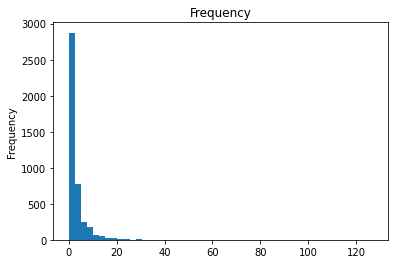

In [65]:
# Visualization to see the distribution patterns of frequency
lifetimes['frequency'].plot(kind='hist', bins=50)
plt.title('Frequency')

In [66]:
# Check the summary of frequency
print(lifetimes['frequency'].describe())

count    4312.000000
mean        2.942254
std         6.019812
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       127.000000
Name: frequency, dtype: float64


In [67]:
print(sum(lifetimes['frequency'] == 0)*100/float(len(raw_data)))

0.36647827622748147


Check summary and distribution of `recency`

Text(0.5, 1.0, 'Recency')

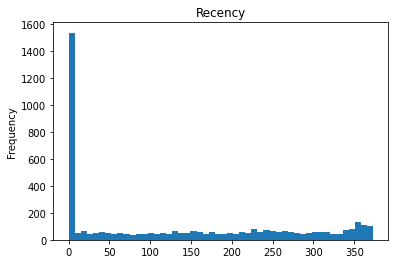

In [68]:
# Visualization to see the distribution patterns of recency
lifetimes['recency'].plot(kind='hist', bins=50)
plt.title('Recency')

In [69]:
# Check the summary of recency
print(lifetimes['recency'].describe())

count    4312.000000
mean      134.324443
std       132.997148
min         0.000000
25%         0.000000
50%       105.500000
75%       254.000000
max       373.000000
Name: recency, dtype: float64


In [70]:
print(sum(lifetimes['recency'] == 0) * 100/float(len(raw_data)))

0.36647827622748147


## Frequency/Recency Analysis Using the BG/NBD Model

In [71]:
# Define the model
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(lifetimes['frequency'], lifetimes['recency'], lifetimes['T'])

<lifetimes.BetaGeoFitter: fitted with 4312 subjects, a: 0.27, alpha: 71.47, b: 193.27, r: 0.87>

In [72]:
# Check the summary of modelling result
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.874613,0.028450,0.818850,0.930376
alpha,71.468893,2.694513,66.187647,76.750139
a,0.266954,1.303753,-2.288402,2.822311
b,193.273528,1007.282900,-1781.000956,2167.548013


### Visualizing our frequency/recency matrix

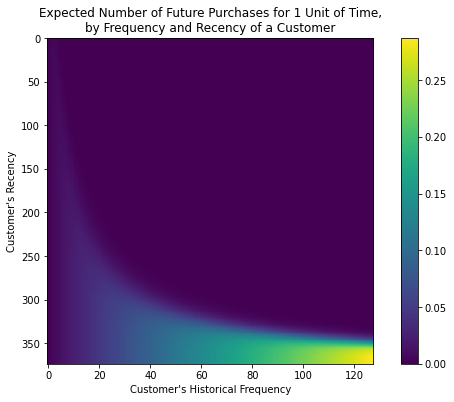

In [73]:
fig = plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(bgf)
plt.show()

We can see that, if a customer has made 120 purchases, and their latest purchase was when they were approximately 350 days old (i.e. Recency: the duration between their first transaction and their latest transaction is 350 days), then they are our best customer (bottom-right).

Customers who have purchased a lot and purchased recently will likely be the best customers in the future. We will never have enough of them.

Customers who have purchased a lot but not recently (top-right corner), have probably gone.
There are also another type of customers that around (40, 100) that represents the customer who buys infrequently, and we have not seen them recently, so they might buy again. However, we are not sure if they have gone or just between purchases.

Another interesting matrix to look at is the probability of still being alive:


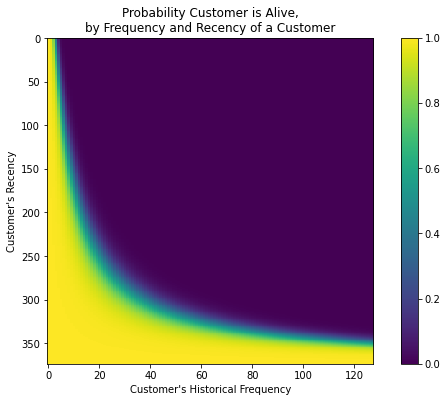

In [74]:
fig = plt.figure(figsize=(10,6))
plot_probability_alive_matrix(bgf)
plt.show()

- If a customer has bought multiple times (frequency) and the time between first & last transaction is high (recency), then his/her probability being alive is high.
- Similarly, if a customer has less frequency (bought once or twice) and the time between first & last transaction is low (recency), then his/her probability being alive is low.

### Ranking customers from best to worst
Let’s return to our customers and rank them from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.


In [75]:
# pick period
t = 30
# Create the value of probability_alive
lifetimes['prob_alive'] = bgf.conditional_probability_alive(
    lifetimes['frequency'], lifetimes['recency'], lifetimes['T'])

# Check the result
lifetimes.head()

,frequency,recency,T,monetary_value,prob_alive
Customer ID,,,,,
12346.0,6.0,196.0,360.0,47.143333,0.965207
12347.0,1.0,37.0,39.0,711.790000,0.998573
12348.0,0.0,0.0,73.0,0.000000,1.000000
12349.0,2.0,182.0,224.0,801.310000,0.997869
12351.0,0.0,0.0,10.0,0.000000,1.000000


In [76]:
# pick period
t = 30
# predict purchases
lifetimes['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(
    t, lifetimes['frequency'], lifetimes['recency'], lifetimes['T']), 2)

# Sort the predicted_purchases
lifetimes.sort_values(by='pred_num_txn', ascending = False).head(10)

,frequency,recency,T,monetary_value,prob_alive,pred_num_txn
Customer ID,,,,,,
14911.0,127.0,373.0,373.0,1192.235748,0.999165,8.59
15311.0,109.0,373.0,373.0,506.240734,0.999115,7.39
12748.0,95.0,370.0,370.0,238.513263,0.999072,6.49
14606.0,94.0,370.0,371.0,196.695851,0.998846,6.41
17841.0,84.0,372.0,372.0,349.544524,0.999035,5.72
14156.0,78.0,367.0,373.0,2506.409487,0.997123,5.29
14527.0,68.0,372.0,372.0,269.995441,0.998975,4.64
13089.0,67.0,369.0,372.0,858.864627,0.998370,4.57
17377.0,50.0,372.0,372.0,263.329000,0.998899,3.43


In [77]:
lifetimes['prob_alive'].describe()

count    4312.000000
mean        0.996071
std         0.026375
min         0.129117
25%         0.997509
50%         0.998383
75%         1.000000
max         1.000000
Name: prob_alive, dtype: float64

> The top 10 customers are expected to be the most predictably valuable purchases

In [78]:
# Check the pattern of frequency and recency on customers with a predicted value of 1-2 and 2-3 transaction
pred_purchase_1 = lifetimes[(lifetimes.pred_num_txn >= 0.6) & (lifetimes.pred_num_txn <= 1.5)]
pred_purchase_2 = lifetimes[(lifetimes.pred_num_txn >= 1.6) & (lifetimes.pred_num_txn <= 2.5)]
pred_purchase_3 = lifetimes[(lifetimes.pred_num_txn >= 2.6) & (lifetimes.pred_num_txn <= 3.5)]

# Check the summary
display(pred_purchase_1.describe())
display(pred_purchase_2.describe())
display(pred_purchase_3.describe())

,frequency,recency,T,monetary_value,prob_alive,pred_num_txn
count,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000
mean,8.339688,238.618718,256.216638,441.480030,0.995462,0.832478
std,4.497959,121.622339,122.921468,404.424247,0.023774,0.222565
min,1.000000,4.000000,6.000000,68.546000,0.496642,0.600000
25%,5.000000,132.000000,154.000000,236.848571,0.997617,0.670000
50%,8.000000,277.000000,308.000000,329.055000,0.998215,0.750000
75%,11.000000,351.000000,365.000000,480.611111,0.998525,0.940000
max,21.000000,372.000000,373.000000,4407.782778,0.998750,1.500000


,frequency,recency,T,monetary_value,prob_alive,pred_num_txn
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,24.627907,309.279070,315.186047,645.125515,0.992666,1.944651
std,7.858945,95.179361,94.865884,709.599879,0.035475,0.294274
min,6.000000,35.000000,46.000000,133.470000,0.765741,1.610000
25%,22.500000,285.000000,290.000000,217.914545,0.998076,1.670000
50%,24.000000,362.000000,368.000000,478.332174,0.998503,1.920000
75%,30.000000,368.500000,371.000000,700.445217,0.998694,2.120000
max,36.000000,372.000000,373.000000,3505.892778,0.998790,2.500000


,frequency,recency,T,monetary_value,prob_alive,pred_num_txn
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,44.272727,362.636364,367.181818,2025.371230,0.998090,3.079091
std,3.608072,12.706477,12.384007,2584.786327,0.000620,0.255987
min,40.000000,327.000000,331.000000,34.632653,0.997126,2.750000
25%,41.500000,361.500000,368.000000,388.807046,0.997592,2.885000
50%,44.000000,366.000000,372.000000,830.413478,0.998234,3.090000
75%,47.000000,370.000000,373.000000,2342.967375,0.998547,3.320000
max,50.000000,373.000000,373.000000,8259.002619,0.998899,3.430000


At this stage, there are 577 customers who are predicted to make 1 purchase in the next period. Those belonging to this group are customers with purchases >= 1 time

while customers who are predicted to make purchases 2 times in the next period are customers who have made purchases >= 6 times

In [79]:
bgf.conditional_expected_number_of_purchases_up_to_time(
    t, lifetimes['frequency'], lifetimes['recency'], lifetimes['T']).sum()

1565.1907898143031

> The count of total **```transactions predicted in the next 1 month is 1565 transactions```**

The predicted_purchases column represents their expected number of purchases while the other three columns represent their current RF metrics. The BG/NBD model believes these individuals will be making more purchases within the near future as they are our current best customers.

#### Assessing model fit
So far, we can predict and we can visualize our customers’ behavior. Now let us assess the model’s correctness. The ﬁrst is to compare your data versus artiﬁcial data simulated with our ﬁtted model’s parameters.

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

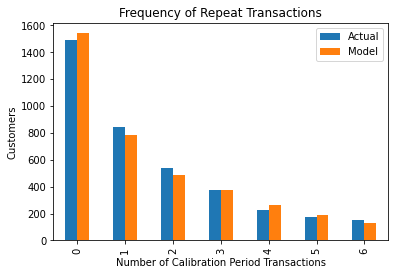

In [80]:
plot_period_transactions(bgf, max_frequency=7)

We can see that our actual data and our simulated data line up well. 
So, we can continue on with our analysis. We now partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (just like cross-validation in machine learning practice).

### More model fitting
With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (think cross-validation in standard machine learning literature).

In [81]:
pd.get_option("display.max_columns")
summary_cal_holdout = calibration_and_holdout_data(
    data_lifetimes, 'Customer ID', 'InvoiceDate',
    calibration_period_end='2010-06-08',
    observation_period_end='2010-12-9'
)

In [82]:
print(summary_cal_holdout.head())

             frequency_cal  recency_cal  T_cal  frequency_holdout  \
Customer ID                                                         
12346.0                5.0         78.0  176.0                1.0   
12349.0                1.0         19.0   40.0                1.0   
12355.0                0.0          0.0   18.0                0.0   
12358.0                1.0        181.0  182.0                1.0   
12359.0                3.0        108.0  185.0                2.0   

             duration_holdout  
Customer ID                    
12346.0                 184.0  
12349.0                 184.0  
12355.0                 184.0  
12358.0                 184.0  
12359.0                 184.0  


With this dataset, we can perform ﬁtting on the _cal columns, and test on the _holdout columns:

In [83]:
# Define model BG/NBD Model
bgf = BetaGeoFitter(penalizer_coef=0.5)

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

invalid value encountered in log



<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

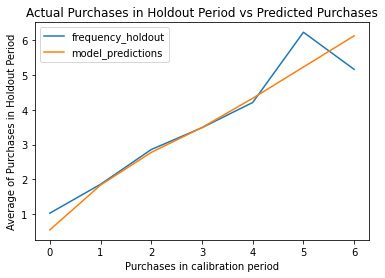

In [84]:
# Check the performance of the model
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In this plot, we separate the data into both a in-sample (calibration) and validation (holdout) period. The plot groups all customers in the calibration period by their number of repeat purchases (x-axis) and then averages over their repeat purchases in the holdout period (y-axis). The orange and blue line presents the model prediction and actual result of the y-axis respectively. As we can see, our model is able to predict well on 1-time to 4-time purchases

### Customer transactions predictions
Based on customer history, we can now predict what an individual’s future purchases might look like:

In [85]:
t = 7 #predict purchases in 10 periods 
individual = lifetimes.loc[14911.0]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_, to_time` 
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

2.2312967130382186

Our model predicts that customer 14911’s future transaction is 2.2 in 7 days.

## Estimating customer lifetime value using gamma-gamma model of monetary value
So far, we didn’t take into account the economic value of each transaction and we focused mainly on transactions’ occurrences. To estimate this we can use the Gamma-Gamma submodel. But ﬁrst we need to create summary data from transactional data also containing economic values for each transaction (i.e. proﬁts or revenues). 

As we are aware by now that, to create a summary dataset which contains information about every customer. We can use the summary_data_from_transaction_data function to generate a summary data frame.

The result contains four columns:

- recency — the time between the first and the last transaction

- frequency — the number of purchases beyond the initial one

- T — the time between the first purchase and the end of the calibration period

- monetary value — the arithmetic mean of customer’s transactions in the calibration period


If we have some customers who did not buy anything in the calibration period and their monetary value in the summary dataset is zero, we must remove them. After that we can build the model. We are only estimating the customers who had at least one repeat purchase with us. Therefore, we are estimating for 2,818 customers.

In [86]:
summary = lifetimes[lifetimes['frequency']>0]
print(summary.head())
print()
print('\nCustomers with atleast 1 repeat purchase\n', len(summary))

             frequency  recency      T  monetary_value  prob_alive  \
Customer ID                                                          
12346.0            6.0    196.0  360.0       47.143333    0.965207   
12347.0            1.0     37.0   39.0      711.790000    0.998573   
12349.0            2.0    182.0  224.0      801.310000    0.997869   
12352.0            1.0     17.0   27.0      200.050000    0.998315   
12356.0            2.0     44.0   59.0     1325.905000    0.998052   

             pred_num_txn  
Customer ID                
12346.0              0.46  
12347.0              0.51  
12349.0              0.29  
12352.0              0.57  
12356.0              0.66  


Customers with atleast 1 repeat purchase
 2818


### The Gamma-Gamma model and the independence assumption


Gamma-Gamma model is based on the assumption that the number of transactions does not depend on their monetary value. The frequency and monetary value are not correlated if the output is close to zero. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [87]:
# Check the correlation
summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.186686
frequency,0.186686,1.000000


It seems that we can use the summary to estimate CLTV. We can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.


In [88]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(summary['frequency'],
        summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2818 subjects, p: 2.21, q: 3.62, v: 501.98>


In [89]:
print(ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).head(10))

Customer ID
12346.0    109.177684
12347.0    554.575835
12349.0    660.029458
12352.0    320.759930
12356.0    989.068913
12358.0    561.730650
12359.0    372.399713
12360.0    380.602184
12361.0    223.960213
12369.0    609.917263
dtype: float64


In [90]:
# Sort customer by top 10 average profit
summary['exp_avg_profit'] = ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value'])
summary.sort_values(by='exp_avg_profit', ascending=False).head(10)

,frequency,recency,T,monetary_value,prob_alive,pred_num_txn,exp_avg_profit
Customer ID,,,,,,,
18102.0,42.0,373.0,373.0,8259.002619,0.998862,2.89,8043.319950
13902.0,4.0,92.0,359.0,8416.400000,0.867649,0.29,6585.067948
14646.0,45.0,363.0,372.0,5393.010222,0.997126,3.09,5265.091449
17940.0,4.0,291.0,371.0,5476.687500,0.996417,0.33,4318.801881
16684.0,18.0,353.0,367.0,4407.782778,0.997663,1.29,4160.901918
16754.0,18.0,269.0,276.0,3505.892778,0.998139,1.62,3314.879698
17511.0,24.0,370.0,372.0,3393.022083,0.998621,1.68,3252.835146
12482.0,5.0,77.0,288.0,3450.728000,0.803865,0.39,2869.064185
18251.0,6.0,272.0,352.0,3113.210000,0.994353,0.48,2668.269154


In [91]:
# Looking for the average profit generated from each 1 customer
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).mean(),
    summary[summary['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 428.1545844791958, Average profit: 415.41009128406586


> Here we can see that the average profit we generate from each 1 customer is 415

While for computing the total CLV using the DCF method adjusting for cost of capital:

In [92]:
# refit the BG model to the summary_with_money_value dataset 
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# predict CLV
summary['predicted_clv'] = ggf.customer_lifetime_value( 
    bgf, #the model to use to predict the number of future transactions 
    summary['frequency'], 
    summary['recency'], 
    summary['T'], 
    summary['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually 
)

# Check the result
summary.head()

,frequency,recency,T,monetary_value,prob_alive,pred_num_txn,exp_avg_profit,predicted_clv
Customer ID,,,,,,,,
12346.0,6.0,196.0,360.0,47.143333,0.965207,0.46,109.177684,617.131336
12347.0,1.0,37.0,39.0,711.790000,0.998573,0.51,554.575835,4078.691341
12349.0,2.0,182.0,224.0,801.310000,0.997869,0.29,660.029458,2240.360692
12352.0,1.0,17.0,27.0,200.050000,0.998315,0.57,320.759930,2823.423126
12356.0,2.0,44.0,59.0,1325.905000,0.998052,0.66,989.068913,9388.528205


In [93]:
# CLV in terms of profit (profit margin is 7%)
profit_margin = 0.07
summary['CLV'] = summary['predicted_clv'] * profit_margin
summary.sort_values(by='CLV', ascending=False).head(10)

,frequency,recency,T,monetary_value,prob_alive,pred_num_txn,exp_avg_profit,predicted_clv,CLV
Customer ID,,,,,,,,,
18102.0,42.0,373.0,373.0,8259.002619,0.998862,2.89,8043.319950,284950.426136,19946.529830
14646.0,45.0,363.0,372.0,5393.010222,0.997126,3.09,5265.091449,200159.409623,14011.158674
14156.0,78.0,367.0,373.0,2506.409487,0.997123,5.29,2475.126575,161817.167750,11327.201743
14911.0,127.0,373.0,373.0,1192.235748,0.999165,8.59,1185.096540,125790.510257,8805.335718
13694.0,48.0,362.0,370.0,2685.693750,0.997292,3.31,2630.999079,107133.088962,7499.316227
16754.0,18.0,269.0,276.0,3505.892778,0.998139,1.62,3314.879698,67342.791381,4713.995397
17511.0,24.0,370.0,372.0,3393.022083,0.998621,1.68,3252.835146,66690.149409,4668.310459
15061.0,40.0,371.0,373.0,2000.241000,0.998620,2.75,1954.704256,65996.716064,4619.770125
16684.0,18.0,353.0,367.0,4407.782778,0.997663,1.29,4160.901918,65291.880840,4570.431659


**```This is where we can see the 10 most valuable customers```**

In [94]:
# Check the statistical summary
summary['predicted_clv'].sum()

8108338.797034506

In [95]:
# Check the statistical summary
summary['exp_avg_profit'].sum()

1206539.6190623739